# PDF of precip rates from interpolated output

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pth='/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/'
exps = ['minus4K','CTL','plus4K'] #reverse order when ready
#color-blind friendly
lineColors = {
    'minus4K':'tab:blue',
    'CTL':'gray',
    'plus4K':'red'}
#increase font size
plt.rcParams.update({'font.size': 14})

In [3]:
def get_plot_pdf_given_dt(exps,grid,dt,fac,units,threshold,bins):
    
    bins_ctr = 0.5*(bins[1:]+bins[:-1])
    fig, ax = plt.subplots()
    for expName in exps:
        fname = pth+'/'+expName+'/TC_3km/latlon/diags_global_nospinup_'+grid+'.nc'
        ds = xr.open_dataset(fname)
        pr = ds.pr.sel(lat=slice(-2.5,20.0))*fac
        if (dt != '6H'):
            # resample data to desired dt
            pr=pr.resample(time=dt).mean()            
        pr_norain = len(pr.where(pr==0).stack(z=('time','lat','lon')).dropna(dim='z'))
        pr = pr.where(pr>threshold).stack(z=('time','lat','lon')).dropna(dim='z')
        N=len(pr)
        print('no. points: %i'%N)
        # pr = pr.stack(z=('time','lat','lon')).dropna(dim='z')
        print(pr.max())
        
        # get and plot histogram
        hist,bin_edges = np.histogram(pr,bins=bins)
        pr_norain=pr_norain/sum(hist)

        hist = hist/np.sum(hist)
        ax.plot(bins_ctr,hist,color=lineColors[expName])
        ax.plot(bins_ctr[0],pr_norain,'*',color=lineColors[expName])

        # plot percentiles
        xtm = np.nanpercentile(pr,90)
        ax.axvline(x=xtm,linestyle='--',color=lineColors[expName])
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.grid(True)
    ax.set_xlabel('rainfall rate (%s)'%units)
    ax.set_ylabel('fraction')

    # add figure label
    label=r'(e) N=%2.1f$\times10^6$'%np.round(N/1e6, 1) # Round to 1 decimal place

    ax.text(0.01, 0.982,label,
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax.transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 
    
    plt.savefig('./Figures/pdf_precip_rates_diff_dt_%s_%s_2.5S-20N.pdf'%(dt,grid),bbox_inches='tight',dpi=300)
    return

no. points: 5925179
<xarray.DataArray 'pr' ()> Size: 8B
array(432.07110596)
no. points: 5925090
<xarray.DataArray 'pr' ()> Size: 8B
array(776.99060059)
no. points: 5922529
<xarray.DataArray 'pr' ()> Size: 8B
array(910.16027832)


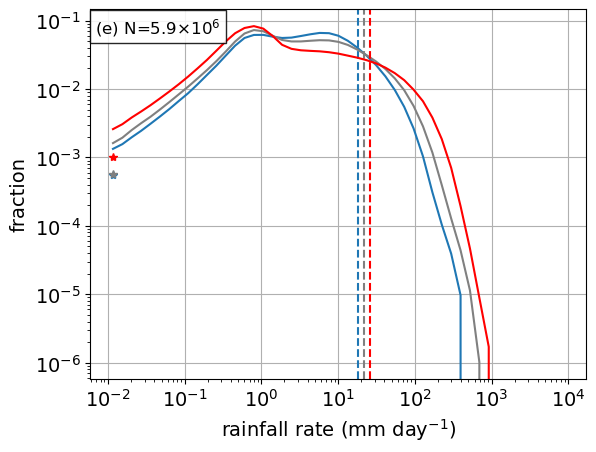

In [4]:
### daily
dt = '1D'
grid = 'r360x180'
fac = (24.0)
units = 'mm day$^{-1}$'
# bins = np.arange(0,40,1)
bins = np.logspace(-2,4,50)
bins_ctr = 0.5*(bins[1:]+bins[:-1])

# get_plot_pdf_given_dt(exps,grid,dt,fac,units,0,bins)

### 6 hourly
dt = '6H'
# fac = (24.0)
# units = 'mm h$^{-1}$'
# bins = np.arange(0,40,1)
bins = np.logspace(-2,4,50)
bins_ctr = 0.5*(bins[1:]+bins[:-1])

get_plot_pdf_given_dt(exps,grid,dt,fac,units,0,bins)

no. points: 92429266
<xarray.DataArray 'pr' ()> Size: 8B
array(1156.82177734)
no. points: 92374698
<xarray.DataArray 'pr' ()> Size: 8B
array(1852.31958008)
no. points: 92024233
<xarray.DataArray 'pr' ()> Size: 8B
array(2480.46020508)


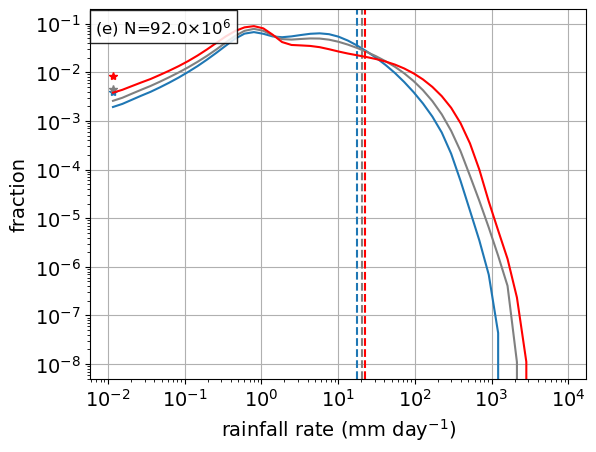

In [5]:
### daily
dt = '1D'
grid = 'r1440x720'
fac = (24.0)
units = 'mm day$^{-1}$'
bins = np.logspace(-2,4,50)
bins_ctr = 0.5*(bins[1:]+bins[:-1])

# get_plot_pdf_given_dt(exps,grid,dt,fac,units,0,bins)

### 6 hourly
dt = '6H'
# fac = (1.0)
# units = 'mm h$^{-1}$'
bins = np.logspace(-2,4,50)
bins_ctr = 0.5*(bins[1:]+bins[:-1])

get_plot_pdf_given_dt(exps,grid,dt,fac,units,0,bins)

### Percentiles and percent change calculations

This is zero-ing out all zero precipitation rates.

In [6]:
from tabulate import tabulate

def perc_change(dT,a,b):
    return (100*((b-a)/a)/dT)

def calculate_percentiles(exps,grid,dt,fac,threshold,percentiles):
    dataOut = []
    for expName in exps:
        data = []
        data.append(expName)
        fname = pth+'/'+expName+'/TC_3km/latlon/diags_global_nospinup_'+grid+'.nc'
        ds = xr.open_dataset(fname)
        pr = ds.pr.sel(lat=slice(-2.5,20.0))*fac
        if (dt != '6H'):
            # resample data to desired dt
            pr=pr.resample(time=dt).mean()
        pr = pr.where(pr>threshold).stack(z=('time','lat','lon')).dropna(dim='z')
        
        # calculate percentiles
        for p in percentiles:
            xtm = np.nanpercentile(pr,p)
            data.append(xtm)
        dataOut.append(data)
        
    # print out
    headers = ['experiment']+percentiles
    # print(tabulate(dataOut, headers=headers, tablefmt="grid"))

    # calculate percent change
    m4K = ['minus4K->CTL']
    p4K = ['CTL->plus4K']
    dT = 4 #fixed at 4K
    for i in np.arange(1,len(percentiles)+1):
        change = perc_change(dT,dataOut[0][i],dataOut[1][i])
        m4K.append(change)
        change = perc_change(dT,dataOut[1][i],dataOut[2][i])
        p4K.append(change)

    # print out
    # print(tabulate([m4K,p4K], headers=headers, tablefmt="grid"))
    
    return dataOut

1 deg x 1 deg

In [7]:
#percentiles = [90.0,99.0,99.9,99.99]
percentiles = [i for i in np.arange(90.0,100.0,0.1)]
print(percentiles)

grid='r360x180'
# --- daily ---#
dt = '1D'
fac=24.0 ## mm/day
print(dt)
# threshold of -1 to include non-rainy points!!!
xtms_1D_1deg = calculate_percentiles(exps,grid,dt,fac,-1,percentiles)

# --- 6H ---#
dt = '6H'
fac=1.0 ## mm/day
print(dt)
xtms_6H_1deg = calculate_percentiles(exps,grid,dt,fac,-1,percentiles)

[90.0, 90.1, 90.19999999999999, 90.29999999999998, 90.39999999999998, 90.49999999999997, 90.59999999999997, 90.69999999999996, 90.79999999999995, 90.89999999999995, 90.99999999999994, 91.09999999999994, 91.19999999999993, 91.29999999999993, 91.39999999999992, 91.49999999999991, 91.59999999999991, 91.6999999999999, 91.7999999999999, 91.89999999999989, 91.99999999999989, 92.09999999999988, 92.19999999999987, 92.29999999999987, 92.39999999999986, 92.49999999999986, 92.59999999999985, 92.69999999999985, 92.79999999999984, 92.89999999999984, 92.99999999999983, 93.09999999999982, 93.19999999999982, 93.29999999999981, 93.3999999999998, 93.4999999999998, 93.5999999999998, 93.69999999999979, 93.79999999999978, 93.89999999999978, 93.99999999999977, 94.09999999999977, 94.19999999999976, 94.29999999999976, 94.39999999999975, 94.49999999999974, 94.59999999999974, 94.69999999999973, 94.79999999999973, 94.89999999999972, 94.99999999999972, 95.09999999999971, 95.1999999999997, 95.2999999999997, 95.399

0.25 deg

In [8]:
# percentiles = [50.0,90.0,99.0,99.9,99.99]

grid='r1440x720'
# --- daily ---#
dt = '1D'
fac=24.0 ## mm/day
print(dt)
# threshold of -1 to include non-rainy points!!!
xtms_1D_qdeg = calculate_percentiles(exps,grid,dt,fac,-1,percentiles)

# --- 6H ---#
dt = '6H'
fac=1.0 ## mm/day
print(dt)
xtms_6H_qdeg = calculate_percentiles(exps,grid,dt,fac,-1,percentiles)

1D
6H


### Plot the rate of change of the percentiles

In [9]:
### first read in saved percentiles from 3 km grid
import pandas as pd
xtms_6H_3km = []
xtms_1D_3km = []
for expName in exps:
    df = pd.read_csv('./extremes_6H_%s_2.5S-20N.csv'%expName)
    xtms_6H_3km.append(df['values'].values)
    df = pd.read_csv('./extremes_1D_%s_2.5S-20N.csv'%expName)
    xtms_1D_3km.append(df['values'].values)

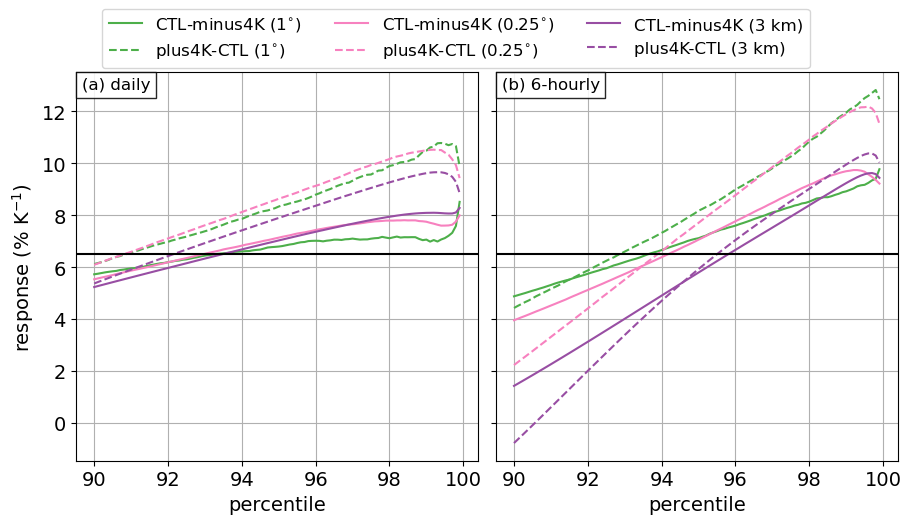

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(9.0, 4.5), constrained_layout=True, sharey=True)

# Plotting with labels for the legend
lines = []  # Store line objects for legend

sensitivity = perc_change(4.0,np.array(xtms_1D_1deg[0][1:]),np.array(xtms_1D_1deg[1][1:]))
line1, = ax[0].plot(percentiles,sensitivity,color='#4daf4a')
lines.append(line1)
sensitivity = perc_change(4.0,np.array(xtms_1D_1deg[1][1:]),np.array(xtms_1D_1deg[2][1:]))
line2, = ax[0].plot(percentiles,sensitivity,color='#4daf4a',linestyle='dashed')
lines.append(line2)
sensitivity = perc_change(4.0,np.array(xtms_1D_qdeg[0][1:]),np.array(xtms_1D_qdeg[1][1:]))
line3, = ax[0].plot(percentiles,sensitivity,color='#f781bf')
lines.append(line3)
sensitivity = perc_change(4.0,np.array(xtms_1D_qdeg[1][1:]),np.array(xtms_1D_qdeg[2][1:]))
line4, = ax[0].plot(percentiles,sensitivity,color='#f781bf',linestyle='dashed')
lines.append(line4)
sensitivity = perc_change(4.0,np.array(xtms_1D_3km[0][:]),np.array(xtms_1D_3km[1][:]))
line5, = ax[0].plot(percentiles,sensitivity,color='#984ea3')
lines.append(line5)
sensitivity = perc_change(4.0,np.array(xtms_1D_3km[1][:]),np.array(xtms_1D_3km[2][:]))
line6, = ax[0].plot(percentiles,sensitivity,color='#984ea3',linestyle='dashed')
lines.append(line6)
# ax[0].set_xscale('log')
ax[0].set_ylabel('response (% K$^{-1}$)')
ax[0].set_xlabel('percentile')
ax[0].axhline(y=6.5,color='k')
ax[0].grid(True)

sensitivity = perc_change(4.0,np.array(xtms_6H_1deg[0][1:]),np.array(xtms_6H_1deg[1][1:]))
ax[1].plot(percentiles,sensitivity,'#4daf4a')
sensitivity = perc_change(4.0,np.array(xtms_6H_1deg[1][1:]),np.array(xtms_6H_1deg[2][1:]))
ax[1].plot(percentiles,sensitivity,'#4daf4a',linestyle='dashed')
sensitivity = perc_change(4.0,np.array(xtms_6H_qdeg[0][1:]),np.array(xtms_6H_qdeg[1][1:]))
ax[1].plot(percentiles,sensitivity,color='#f781bf')
sensitivity = perc_change(4.0,np.array(xtms_6H_qdeg[1][1:]),np.array(xtms_6H_qdeg[2][1:]))
ax[1].plot(percentiles,sensitivity,color='#f781bf',linestyle='dashed')
sensitivity = perc_change(4.0,np.array(xtms_6H_3km[0][:]),np.array(xtms_6H_3km[1][:]))
ax[1].plot(percentiles,sensitivity,color='#984ea3')
sensitivity = perc_change(4.0,np.array(xtms_6H_3km[1][:]),np.array(xtms_6H_3km[2][:]))
ax[1].plot(percentiles,sensitivity,color='#984ea3',linestyle='dashed')
ax[1].set_xlabel('percentile')
ax[1].axhline(y=6.5,color='k')
ax[1].grid(True)

# Create a common legend outside the axes
labels = [r'CTL-minus4K (1$^{\circ}$)',
          r'plus4K-CTL (1$^{\circ}$)',
          r'CTL-minus4K (0.25$^{\circ}$)',
          r'plus4K-CTL (0.25$^{\circ}$)',
          'CTL-minus4K (3 km)',
          'plus4K-CTL (3 km)']
fig.legend(lines, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), fontsize=12) #ncol adjusts the number of columns in the legend

# fig.legend(handles, labels, loc='upper center')

# add labels
label='(a) daily'
ax[0].text(0.015, 0.987,label,
horizontalalignment='left',
verticalalignment='top',
transform=ax[0].transAxes,
fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 

label='(b) 6-hourly'
ax[1].text(0.015, 0.987,label,
horizontalalignment='left',
verticalalignment='top',
transform=ax[1].transAxes,
fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 

plt.savefig('./Figures/response_extreme_rainfall_2.5S-20N.jpeg',bbox_inches='tight',dpi=600)